In [1]:
# First we need to mount the Google drive 
import os
from google.colab import drive
drive.mount('/content/gdrive')
# Here specify the path to your directory
!ls "/content/gdrive/My Drive/ResNet_CIFAR10_TF" 
root_path = 'gdrive/My Drive/ResNet_CIFAR10_TF' 
path = '/content/gdrive/My Drive/ResNet_CIFAR10_TF'
os.chdir(path)

Mounted at /content/gdrive
ResNet110v1e200.png   saved_models	       tf_resnetv2_cifar10.ipynb
ResNet20v1e200vf.png  TF_ResNet50v1e200.png
ResNet_CIFAR10.ipynb  tf_resnet_cifar10.ipynb


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math
import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

# training parameters
batch_size = 128 # 32 # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

n = 3

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 2

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 6 + 2 # n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%de%d' % (depth, version, epochs)

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=False):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder
    Stacks of 2 x (3 x 3) BN-ReLU-Conv2D
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (e.g. n = 3, 18, etc')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    # Conv, BN, ReLU
    x = resnet_layer(inputs=inputs, conv_first=True)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            # BN, ReLU, Conv
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            # BN, ReLU, Conv
            y = resnet_layer(inputs=y,
                             num_filters=num_filters)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [5]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
# else:
#     model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


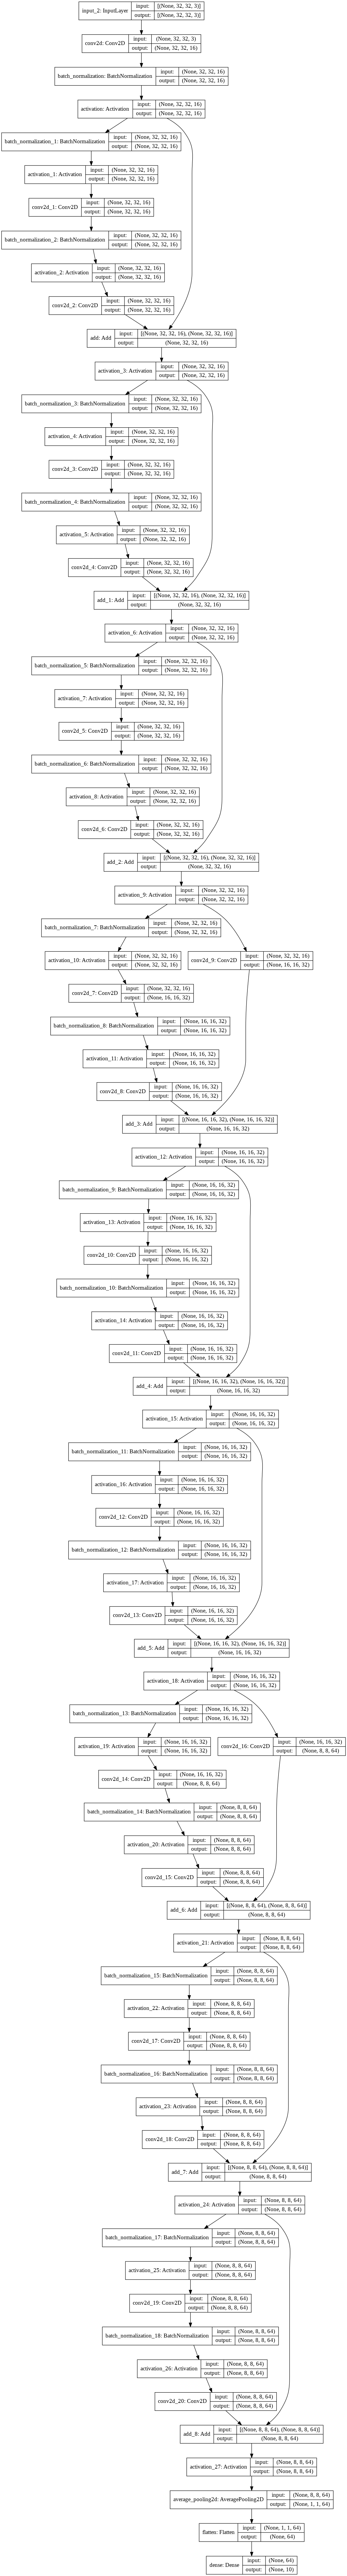

In [6]:
# enable this if pydot can be installed
# pip install pydot
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)

In [7]:
print('model_type:', model_type)

# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = 'cifar10_%s.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_directory = os.path.join(save_dir, model_type)
print('model_directory:', model_directory)

if not os.path.isdir(model_directory):
    os.makedirs(model_directory)

filepath = os.path.join(model_directory, model_name)
print('filepath:', filepath)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

model_type: ResNet20v2e200
model_directory: /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200
filepath: /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200/cifar10_ResNet20v2e200.h5


In [8]:
class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self, batch, logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr', 0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(model_directory)):
      with open(model_directory + '/model_history.csv', 'a') as f:
        y = csv.DictWriter(f, logs.keys())
        y.writeheader()

    with open(model_directory + '/model_history.csv', 'a') as f:
      y = csv.DictWriter(f, logs.keys())
      y.writerow(logs)

In [9]:
callbacks = [StoreModelHistory(), checkpoint, lr_reducer, lr_scheduler]

In [10]:
# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
391/391 [==============================] - 60s 67ms/step - loss: 1.7829 - acc: 0.3994 - val_loss: 1.7279 - val_acc: 0.4378

Epoch 00001: val_acc improved from -inf to 0.43780, saving model to /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200/cifar10_ResNet20v2e200.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
Learning rate:  0.001
391/391 [==============================] - 26s 66ms/step - loss: 1.3999 - acc: 0.5483 - val_loss: 1.6899 - val_acc: 0.4952

Epoch 00002: val_acc improved from 0.43780 to 0.49520, saving model to /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200/cifar10_ResNet20v2e200.h5
Epoch 3/200
Learning rate:  0.001
391/391 [==============================] - 26s 66ms/step - loss: 1.2151 - acc: 0.6221 - val_loss: 1.4457 - val_acc: 0.5849

Epoch 00003: val_acc improved from 0.49520 to 0.58490, saving model to /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200/cifar10_ResNet20v2e200.h5
Epoch 4/200
Learning rate:  0.001
391/391 [==============================] - 26s 67ms/step - loss: 1.0651 - acc: 0.6745 - val_loss: 1.1759 - val_acc: 0.6498

Epoch 00004: val_acc improved from 0.58490 to 0.64980, saving model to /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200/cifar10_ResNet20v2e200.h5
Epoch 5/200
Learning r

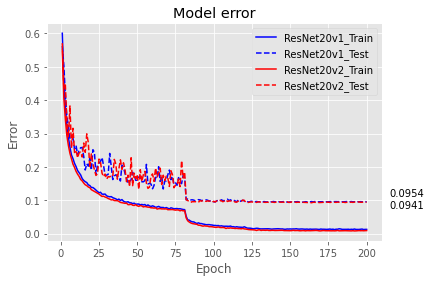

In [12]:
EPOCH = 200 # number of epochs the model has trained for

ex_history_df = pd.read_csv('/content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v2e200' + 
                            '/model_history.csv', sep=',')
history_df = pd.read_csv('/content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNet20v1e200' + 
                         '/model_history.csv', sep=',') # model_directory

# Plot training & validation error values
plt.style.use("ggplot")
plt.plot(range(1, EPOCH + 1),
         1 - ex_history_df['acc'], 'b')
plt.plot(range(1, EPOCH + 1),
         1 - ex_history_df['val_acc'], 'b', 
         linestyle='--')
plt.plot(range(1, EPOCH + 1),
         1 - history_df['acc'], 'r')
plt.plot(range(1, EPOCH + 1),
         1 - history_df['val_acc'], 'r', 
         linestyle='--')
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
legend_1 = plt.legend(['ResNet20v1_Train', 'ResNet20v1_Test', 'ResNet20v2_Train', 'ResNet20v2_Test'], loc='upper right')
plt.annotate('%.4f' % float(1 - history_df['val_acc'][-1:]), xy=(1, float(1 - history_df['val_acc'][-1:])), xytext=(8, -6), 
              xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.annotate('%.4f' % float(1 - ex_history_df['val_acc'][-1:]), xy=(1, float(1 - ex_history_df['val_acc'][-1:])), xytext=(8, 6), 
              xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.show()